In [1]:
from tn import *

cuda:0


{'shape': (8, 8, 16, 8, 8), 'edges': [(1, 2), (2, 3), (3, 4), (4, 5)], 'ranks': [12, 12, 12, 12], 'iters': 40}


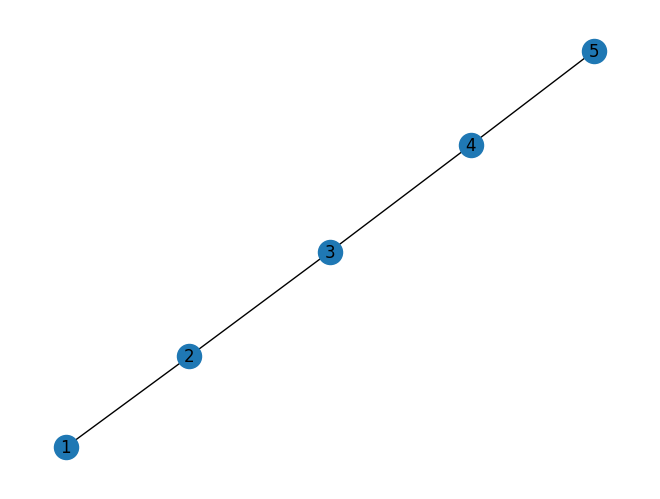

Original: 65536
Tensor Network: 4800
CR: 13.653333333333334
epoch 10/40 err: 0.14057948370777848
epoch 20/40 err: 0.14045057820081258
epoch 30/40 err: 0.1404426251266332
epoch 40/40 err: 0.14044094142934566
time_resh: 153.40940141677856
Time: 1.49s

Rel Error: 0.14044085929777064
Original: 65536
Tensor Network: 4800
CR: 13.653333333333334
epoch 10/40 err: 0.14551271676028388
epoch 20/40 err: 0.18861847463267747
epoch 30/40 err: 0.14216165268002448
epoch 40/40 err: 0.14087611557949467
time_resh: 20.923261165618896
Time: 0.21s

Rel Error: 0.14082991656855592
Original: 65536
Tensor Network: 4800
CR: 13.653333333333334
epoch 10/40 err: 0.2096011893309113
epoch 20/40 err: 0.18510088878410116
epoch 30/40 err: 0.14555706781078506
epoch 40/40 err: 0.14208168390316403
time_resh: 20.58685302734375
Time: 0.21s

Rel Error: 0.14194214235723535
Original: 65536
Tensor Network: 4800
CR: 13.653333333333334
epoch 10/40 err: 1.1648988483948588
epoch 20/40 err: 0.2332258577794316
epoch 30/40 err: 0.142804

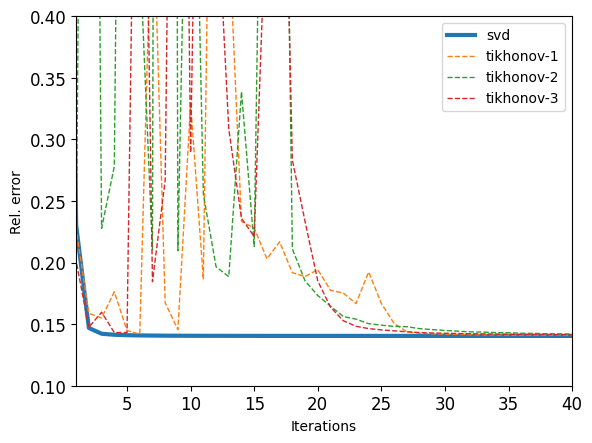

In [3]:
# Load image using PIL

# image = Image.open('doradito.png')  # Replace with your image path
# image_shape = (4, 2, 131, 4, 3, 41)

image = Image.open('lenna-lr.png').convert("L")

data = [
    {
        "shape": (8, 8, 16, 8, 8),
        "edges": [(1, 2), (2, 3), (3, 4), (4, 5)],
        "ranks": [12, 12, 12, 12],
        "iters": 40
    }
]

i = 1
for d in data:
    print(d)
    image_shape = d["shape"]
    
    # Define transformation: convert image to tensor
    transform = transforms.ToTensor()
    # device = "cpu"
    
    # Apply transformation
    image_tensor = transform(image).squeeze(0)
    
    # Optional: check shape
    # print(image_tensor.shape)  # (C, H, W)
    objective = image_tensor.reshape(image_shape).to(device)
    
    
    G = nx.Graph()
    G.add_edges_from(d["edges"])
    
    nx.draw(G, with_labels=True)
    plt.savefig("results/tikhonov/graph-" + str(i) + ".png", format="PNG")
    plt.show()
    plt.clf()
    
    ntn = TN(G, list(objective.shape), d["ranks"])

    print("Original: " + str(torch.numel(objective)))
    print("Tensor Network: " + str(ntn.get_tn_size()))
    print("CR: " + str(torch.numel(objective) / ntn.get_tn_size()))
    
    start_time = time.time()
    
    rel_err, graph = TN.als(ntn, objective, 1e-3, iter_num=d["iters"], print_iters=True)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time: {elapsed_time:.2f}s" + "\n")
    
    # If image_tensor is (C, H, W), convert to (H, W, C)
    image_np = TN.eval(ntn).reshape(image_tensor.shape).cpu().numpy()
    
    # Show image
    norm = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))
    plt.imshow(norm)
    plt.imsave("results/lenna-comp" + str(i) + ".png", norm)
    plt.clf()

    graph_data = {}
    graph_data["svd"] = {"data": graph[1]}

    print("Rel Error: " + str(rel_err))

    with open("results/data" + str(i) + ".txt", "w") as f:
        f.write("Arbitrary structure\n")
        f.write("Shape: " + str(d["shape"]) + "\n");
        f.write("Edges: " + str(d["edges"]) + "\n");
        f.write("Ranks: " + str(d["ranks"]) + "\n\n");
        f.write("Original: " + str(torch.numel(objective)) + "\n")
        f.write("Tensor Network: " + str(ntn.get_tn_size()) + "\n")
        f.write("CR: " + str(torch.numel(objective) / ntn.get_tn_size()) + "\n")
        f.write("Rel Error: " + str(rel_err) + "\n")
        f.write("Iters: " + str(d["iters"]) + "\n")
        f.write(f"Time: {elapsed_time:.2f}s" + "\n")

    del ntn
    # ---------------------------------------------------------------------------------
    for k in range(1, 4):
        ntn = TN(G, list(objective.shape), d["ranks"])
    
        print("Original: " + str(torch.numel(objective)))
        print("Tensor Network: " + str(ntn.get_tn_size()))
        print("CR: " + str(torch.numel(objective) / ntn.get_tn_size()))
        
        start_time = time.time()
        
        rel_err, graph = TN.als(ntn, objective, 1e-3, iter_num=d["iters"], print_iters=True, tikhonov=True)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Time: {elapsed_time:.2f}s" + "\n")
        
        # If image_tensor is (C, H, W), convert to (H, W, C)
        image_np = TN.eval(ntn).reshape(image_tensor.shape).cpu().numpy()
        
        # Show image
        norm = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))
        plt.imshow(norm)
        plt.imsave("results/lenna-comp" + str(i) + ".png", norm)
        plt.clf()
    
        graph_data["tikhonov-" + str(k)] = {"data": graph[1]}
    
        print("Rel Error: " + str(rel_err))
    
        with open("results/data-tiknov" + str(i) + ".txt", "w") as f:
            f.write("Arbitrary structure\n")
            f.write("Shape: " + str(d["shape"]) + "\n");
            f.write("Edges: " + str(d["edges"]) + "\n");
            f.write("Ranks: " + str(d["ranks"]) + "\n\n");
            f.write("Original: " + str(torch.numel(objective)) + "\n")
            f.write("Tensor Network: " + str(ntn.get_tn_size()) + "\n")
            f.write("CR: " + str(torch.numel(objective) / ntn.get_tn_size()) + "\n")
            f.write("Rel Error: " + str(rel_err) + "\n")
            f.write("Iters: " + str(d["iters"]) + "\n")
            f.write(f"Time: {elapsed_time:.2f}s" + "\n")
        del ntn
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    # Print graph
    plt.ylim(0.1, 0.4)
    plt.xlim(1, 40)
    # plt.xticks(range(0, 100, 10))
    for k in graph_data.keys():
        print(k)
        if 'tikhonov' in k:
            plt.plot(graph_data[k]["data"], label=k, linestyle='dashed', linewidth=1)
        else:
            plt.plot(graph_data[k]["data"], label=k, linewidth=3)
    plt.xlabel("Iterations")
    plt.ylabel("Rel. error")
    plt.legend()
    plt.savefig('results/tikhonov/rel_err_fig-' + str(i) + ".png")
    plt.show()

    i += 1